In [2]:
from typing import List
import numpy as np
import imageio
import cv2
import copy
import os

# CALIBRACIÓN DE LA CÁMARA
En este apartado se realiza la calibración de la cámara. Para ello se trabajará con las imágenes que se han sacado de ejecutar el archivo de sacarFotos.py en la Raspberry contenidas en la carpeta de 'assets'. En ellas aparece un patrón de calibración en diferentes posiciones y orientaciones, donde el patrón es un tablero de ajedrez. 

### Número óptimo de imágenes para calibrar la cámara

Como en la primera práctica de la asignatura, para definir el número de imágenes óptimo para calibrar nuestra cámara se han cargado todas las imágenes disponibles sacadas con la cámara y de ahí se han seleccionado distinto número para comprobar los rmse. En la primera práctica nos salió un óptimo del error en 14. Sin embargo, para esta cámara en específico, se ha podido comprobar que el valor óptimo de imágenes, con el que se consigue minimizar el rmse, es 12. Para demostrarlo, se ha pintado un diagrama de Pareto en que se muestra la evolución de los errores de calibración para distinto número de imágenes usadas para el procesamiento.

In [3]:
def load_images(filenames: List) -> List:
    return [imageio.imread(filename) for filename in filenames]

In [4]:
# Lista con todas las rutas de las fotos para calibrar la cámara
imgs_path = os.path.join(".", "..", "assets", "fotos_originales")
imgs_path = [os.path.join(imgs_path, img_name) for img_name in os.listdir(imgs_path)]
imgs = load_images(imgs_path)
imgs = imgs[:12]

C:\Users\Almudena\AppData\Local\Temp\ipykernel_14660\283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


In [5]:
# Buscamos las esquinas del tablero con cv2.findChessboardCorners()
corners = [cv2.findChessboardCorners(img, patternSize = (7, 7)) for img in imgs]

In [6]:
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 24, 0.01)

# Para refinar la detección de esquinas con cv2.cornerSubPix() introducimos imágenes en escala de grises
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]

corners_refined = [cv2.cornerSubPix(i, cor[1], (7, 7), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_gray, corners_copy)]

In [7]:
# Dibujamos las imágenes con las esquinas para comprobar que han funcionado correctamente usando la libreria cv2
def show_image(name, img):
    cv2.imshow(name, img)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
def write_image(path, img):
    cv2.imwrite(path, img)

imgs_copy = copy.deepcopy(imgs)

imgs_draw = [cv2.drawChessboardCorners(img, patternSize=(7, 7), corners=corner[1], patternWasFound=corner[0]) for img, corner in zip(imgs, corners)]

results = os.path.join(".", "..", "assets", "fotos_esquinas")

for i, img in enumerate(imgs_draw):
    name = f"img_{i}"
    show_image(name, img)
    write_image(results+f"\{name}.jpg", img)

In [8]:
# Definimos un método para obtener los puntos del tablero
def get_chessboard_points(chessboard_shape, dx, dy):
    cols, rows = chessboard_shape
    list = []
    
    for i in range(rows):
        for j in range(cols):
            x = j * dx
            y = i * dy
            z = 0.0
            list.append([x, y, z])
    
    return np.array(list, dtype=np.float32)

chessboard_points = np.array([get_chessboard_points((7, 7), 24, 24) for _ in range(len(imgs))])

In [9]:
# Utilizamos la funcón cv2.calibrateCamera() para obtener los parámetros de la cámara

# Filtramos los datos para obtener solo aquellos con las detecciones adecuadas y convertimos a numpy array
valid_corners = [cor[1] for cor in corners if cor[0]]
valid_corners = np.asarray(valid_corners, dtype=np.float32)

# Obtenemos los parametros extrínsecos
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points, valid_corners, imageSize=(7, 7), cameraMatrix=None, distCoeffs=None)
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))

# Mostramos los valores de los outputs de los parámetros extrínsecos
print("Intrinsics:\n", intrinsics)
print("Extrinsics:\n", extrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[1.47547376e+03 0.00000000e+00 5.72146255e+02]
 [0.00000000e+00 1.46329467e+03 3.19883097e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsics:
 [array([[ 9.43647220e-01, -8.64892582e-03,  3.30840023e-01,
         1.51743265e+01],
       [ 7.82572595e-02,  9.77140578e-01, -1.97666619e-01,
        -6.70588393e+01],
       [-3.21567608e-01,  2.12418189e-01,  9.22752831e-01,
         4.91753337e+02]]), array([[-2.90421524e-01, -7.12619646e-01,  6.38614577e-01,
         1.28930256e+02],
       [ 8.75571260e-01,  7.13426780e-02,  4.77791996e-01,
        -4.83692751e+01],
       [-3.86044437e-01,  6.97913649e-01,  6.03229832e-01,
         5.56269888e+02]]), array([[ 8.26777859e-01, -5.57940339e-01,  7.17004220e-02,
         4.48834211e+01],
       [ 2.99617767e-01,  5.44648835e-01,  7.83317841e-01,
         2.23914125e+01],
       [-4.76096173e-01, -6.26147128e-01,  6.17472436e-01,
         7.71736234e+02]]), array([[ 9.32810311e-01,  7.13030657e-02, -3.53243254e-01

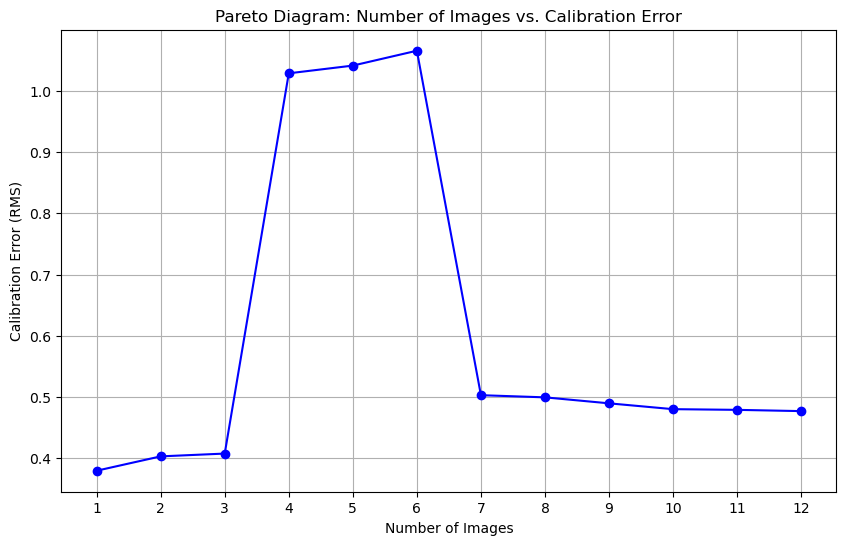

In [10]:
# Comprobación de número óptimo de imágenes para calibrar
import matplotlib.pyplot as plt

images_count = [i for i in range(1, 13)]
calibration_errors = []

for count in images_count:
    rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(chessboard_points[:count], valid_corners[:count], imageSize=(7, 7), cameraMatrix=None, distCoeffs=None)
    calibration_errors.append(rms)
    
plt.figure(figsize=(10,6))
plt.plot(images_count, calibration_errors, marker='o', linestyle='-', color='b', label='Calibration Error (RMS)')
plt.xlabel('Number of Images')
plt.ylabel('Calibration Error (RMS)')
plt.title('Pareto Diagram: Number of Images vs. Calibration Error')
plt.grid(True)
plt.xticks(images_count)
plt.show()

# SISTEMA DE SEGURIDAD

En este apartado del proyecto final, se va a llevar a cabo un proceso para la detección de patrones. Para lo que se deberá implementar un módulo capaz de diferenciar patrones sencillos a través del procesado de las imágenes. Algunos ejemplos serían círculos, líneas (horizontales, verticales), cuadrados o triángulos dibujados con líneas negras sobre fondos blancos. 

Para realizar la extracción de la información se va a implemetar un decodificador que sea capaz de memorizar hasta cuatro patrones, garantizando que acepte o bloquee el paso al siguiente bloque en función de si se han introducido correctamente los patrones en el orden adecuado. Para ello se ha implementado una lógica con la que se comprueba la secuencia dibujada.


In [11]:
# Definir la secuencia esperada para la contraseña
expected_sequence = ["circle", "line", "square", "triangle"]

# Inicializar la memoria de los patrones detectados
detected_sequence = []

def detect_patterns(frame):
    
    # Convertir el frame a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Aplicar un desenfoque para reducir ruido
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detectar bordes en el frame
    edges = cv2.Canny(blurred, 50, 150)
    
    # Encontrar contornos en el frame
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Lista para almacenar las formas detectadas en el frame
    detected_shapes = []
    
    for contour in contours:
        
        # Hacer una aproximacion del contorno
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)
        
        # Se ignoran los contornos muy pequeños
        if area < 500:
            continue
        
        # Clasificar formas
        if len(approx) == 2:
            detected_shapes.append("line")
        
        elif len(approx) == 3:
            detected_shapes.append("triangle")
        
        elif len(approx) == 4:
            
            # Comprobar si es un cuadrado (proporción de lados similar)
            (x, y, w, h) = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.9 <= aspect_ratio <= 1.1:
                detected_shapes.append("square")
                
        elif len(approx) >= 8:
            detected_shapes.append("circle")
            
        else:
            detected_shapes.append("unknown")
    
    return detected_shapes

In [15]:
def update_sequence(detected_shapes):
    
    global detected_sequence
    
    # Agregar los patrones detectados a la secuencia
    detected_sequence.extend(detected_shapes)
    
    # Se mantienen solo los ultimos 4 patrones
    if len(detected_sequence) > 4:
        detected_sequence = detected_sequence[-4:]
    
    # Validacion de la secuencia
    if detected_sequence == expected_sequence:
        
        print("Access Granted: Sequence Correct!")
        detected_sequence.clear()  # Resetear
        return "Access Granted"
    
    elif len(detected_sequence) == 4 and detected_sequence != expected_sequence[:len(detected_sequence)]:
        
        print("Access Denied: Sequence Incorrect!")
        detected_sequence.clear()  # Resetear
        return "Access Denied"
    
    return "Processing"

In [16]:
# Captura en tiempo real desde la cámara
cap = cv2.VideoCapture(0)

print("Presiona 'q' para salir.")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detectar patrones en el fotograma actual
    shapes = detect_patterns(frame)
    
    if len(shapes) == 0:
        # No se detectan formas
        cv2.putText(frame, "No shapes detected", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    else:
        # Procesar formas detectadas
        result = update_sequence(shapes)
        
        # Mostrar información en pantalla según el resultado
        if result == "Access Granted":
            cv2.putText(frame, "Access Granted", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif result == "Access Denied":
            cv2.putText(frame, "Access Denied! Try Again", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        else:
            cv2.putText(frame, "Processing Shapes...", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    
    # Mostrar el video en tiempo real
    cv2.imshow("Pattern Detection", frame)
    
    # Salir con la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Presiona 'q' para salir.
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorrect!
Access Denied: Sequence Incorr